In [109]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [110]:
data = yf.download('ETH-USD',start='2018-01-01', end='2024-12-31', interval='1d')
data.sort_index(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
Date,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824
...,...,...,...,...,...
2024-12-26,3331.225830,3512.604492,3302.306396,3493.304199,22247726776
2024-12-27,3328.916992,3436.710693,3302.575684,3331.053711,24091627403


In [111]:
data.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2024-12-21', '2024-12-22', '2024-12-23', '2024-12-24',
               '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-28',
               '2024-12-29', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=2556, freq=None)

As we can see, the dataset is already formatted to have the date as the index along with its datatype being in the correct datetime format.
No form of index resetting is required.

In [112]:
data.columns

MultiIndex([( 'Close', 'ETH-USD'),
            (  'High', 'ETH-USD'),
            (   'Low', 'ETH-USD'),
            (  'Open', 'ETH-USD'),
            ('Volume', 'ETH-USD')],
           names=['Price', 'Ticker'])

In [113]:
# Flatten Multi-index to get only the first level
data.columns = data.columns.get_level_values(0)
# Remove Multi-index column list name
data.columns.name = None
data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [114]:
print('Column datatypes')
print(data.dtypes)
print('\nEmpty Cells Present?')
print(data.isna().sum())
print('\nNull Values Present?')
print(data.isnull().sum())

Column datatypes
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Empty Cells Present?
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Null Values Present?
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [115]:
data

,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824
...,...,...,...,...,...
2024-12-26,3331.225830,3512.604492,3302.306396,3493.304199,22247726776
2024-12-27,3328.916992,3436.710693,3302.575684,3331.053711,24091627403
2024-12-28,3397.902344,3419.920166,3318.033936,3328.774658,14305648523


## Exploratory Data Analysis (EDA)

In [116]:
data.describe()

,Close,High,Low,Open,Volume
count,2556.000000,2556.000000,2556.000000,2556.000000,2.556000e+03
mean,1510.652643,1550.834917,1464.885519,1509.803119,1.324624e+10
std,1230.793469,1263.550696,1194.078765,1230.622649,1.057807e+10
min,84.308296,85.342743,82.829887,84.279694,9.484880e+08
25%,262.296455,269.522560,249.106083,262.361084,5.862294e+09
50%,1465.703552,1540.519897,1419.840454,1460.496826,1.080299e+10
75%,2430.952637,2498.217773,2340.133240,2428.475281,1.787779e+10
max,4812.087402,4891.704590,4718.039062,4810.071289,8.448291e+10


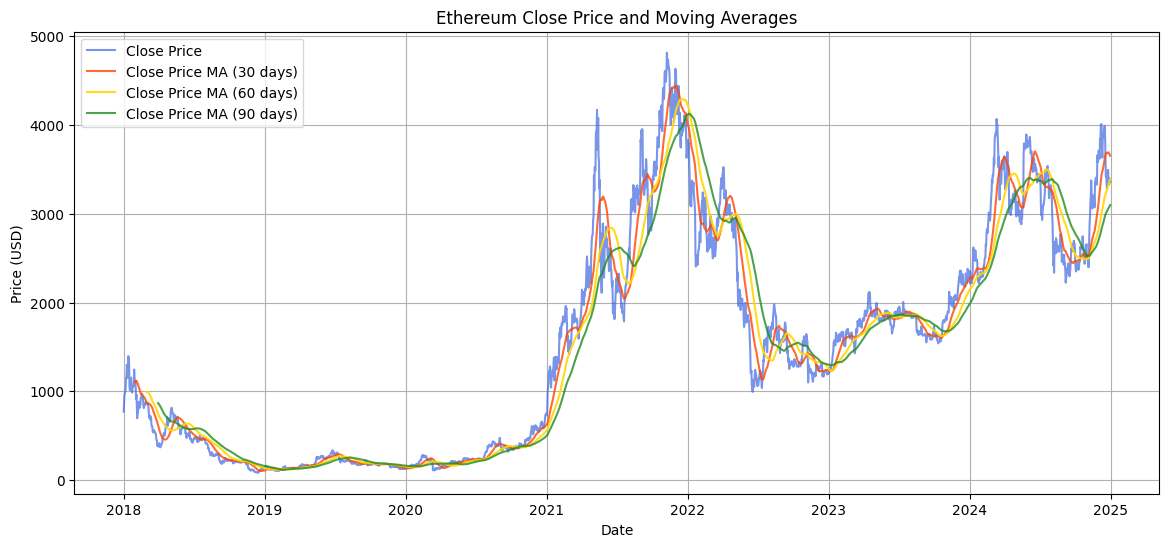

In [117]:
plt.figure(figsize=(14, 6))

# Lineplots of Closing Price and Moving Averages of 30, 60, & 90 days
sns.lineplot(data=data, x=data.index, y=data['Close'], alpha=0.7, color='royalblue', label='Close Price')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=30).mean(), alpha=0.8, color='orangered', label='Close Price MA (30 days)')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=60).mean(), alpha=0.9, color='gold', label='Close Price MA (60 days)')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=90).mean(), alpha=0.8, color='forestgreen', label='Close Price MA (90 days)')

plt.title('Ethereum Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Strong evidence that the data is not stationary. This confirms our non-stationary assumption from visual inspection.

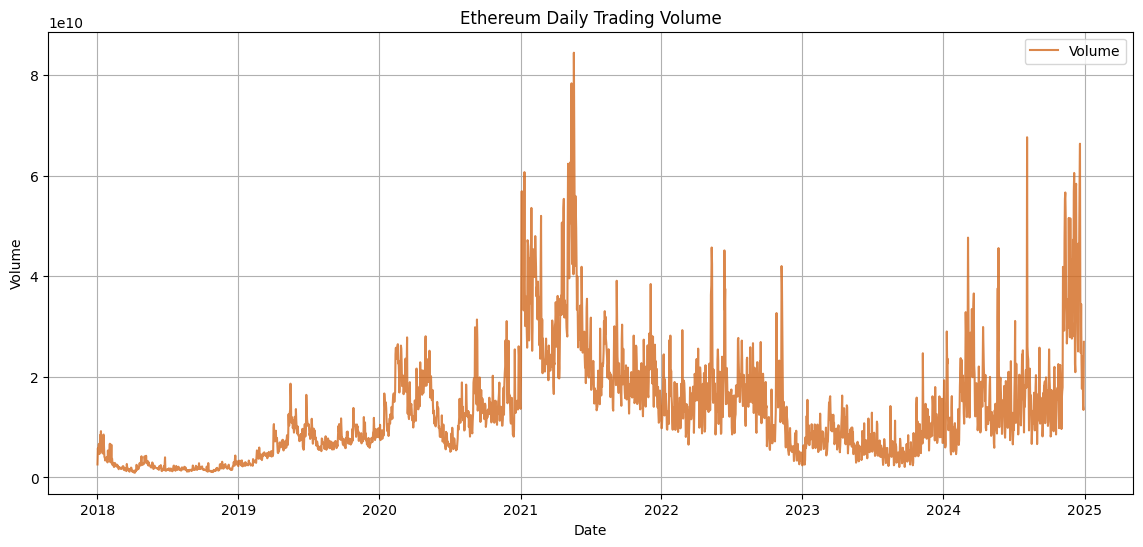

In [118]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=data, x=data.index, y=data['Volume'], alpha=0.8, color='chocolate', label='Volume')
plt.title('Ethereum Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

<Figure size 1400x600 with 0 Axes>

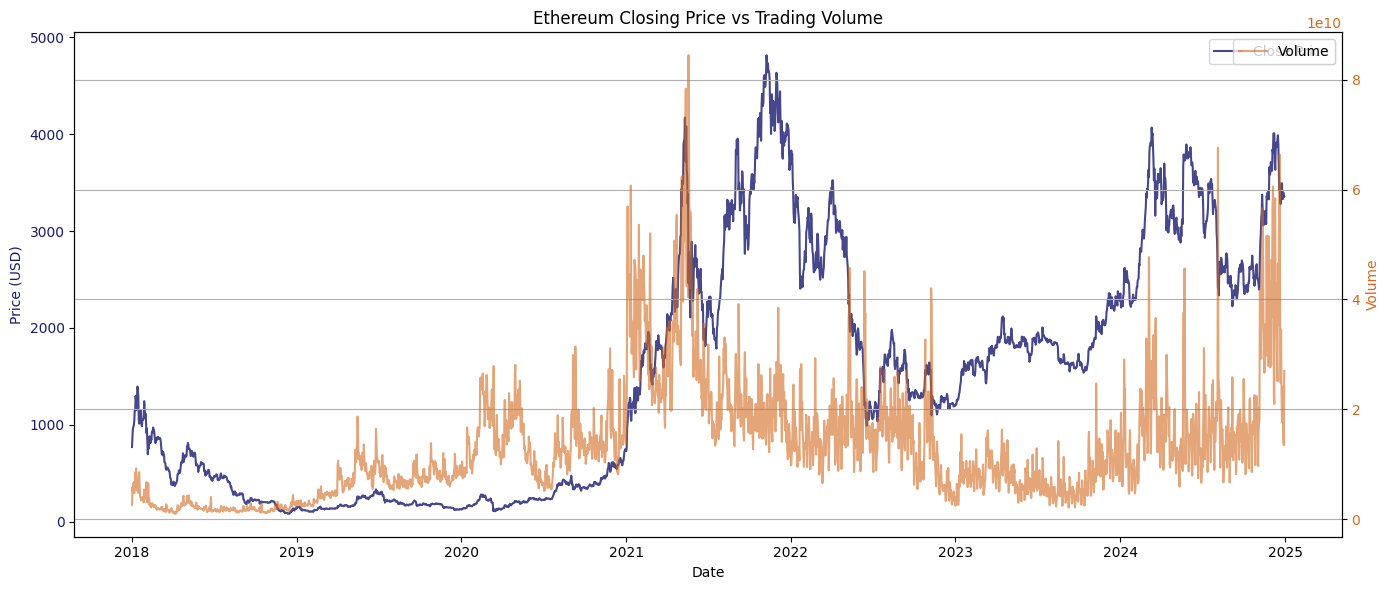

In [119]:
plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(14, 6))

# Closing Price Plot
sns.lineplot(ax=ax1, data=data, x=data.index, y='Close', color='midnightblue', alpha=0.8, label='Close Price')
ax1.set_ylabel('Price (USD)', color='midnightblue')
ax1.tick_params(axis='y', labelcolor='midnightblue')

# Trading Volume Plot
ax2 = ax1.twinx()
sns.lineplot(ax=ax2, data=data, x=data.index, y='Volume', color='chocolate', alpha=0.6, label='Volume')
ax2.set_ylabel('Volume', color='chocolate')
ax2.tick_params(axis='y', labelcolor='chocolate')

plt.title('Ethereum Closing Price vs Trading Volume')
ax1.set_xlabel('Date')
fig.tight_layout()
plt.grid(True)
plt.show()

In [120]:
# Check for stationarity using Augmented Dickey Fuller test
adf_close = adfuller(data['Close'])
print("ADF Statistic:", adf_close[0])
print("p-value:", adf_close[1])

ADF Statistic: -1.215198770290385
p-value: 0.6670236509854335


In [121]:
eth_returns = data['Close'].pct_change().dropna()
eth_diff = data['Close'].diff().dropna()

print(f'Percentage change/Returns:\n{eth_returns}')
print(f'\nFirst difference:\n{eth_diff}')

Percentage change/Returns:
Date
2018-01-02    0.144702
2018-01-03    0.088503
2018-01-04    0.018907
2018-01-05    0.017125
2018-01-06    0.044061
                ...   
2024-12-26   -0.046378
2024-12-27   -0.000693
2024-12-28    0.020723
2024-12-29   -0.014241
2024-12-30    0.002054
Name: Close, Length: 2555, dtype: float64

First difference:
Date
2018-01-02    111.802979
2018-01-03     78.276001
2018-01-04     18.202026
2018-01-05     16.797974
2018-01-06     43.960083
                 ...    
2024-12-26   -162.009521
2024-12-27     -2.308838
2024-12-28     68.985352
2024-12-29    -48.388916
2024-12-30      6.879150
Name: Close, Length: 2555, dtype: float64


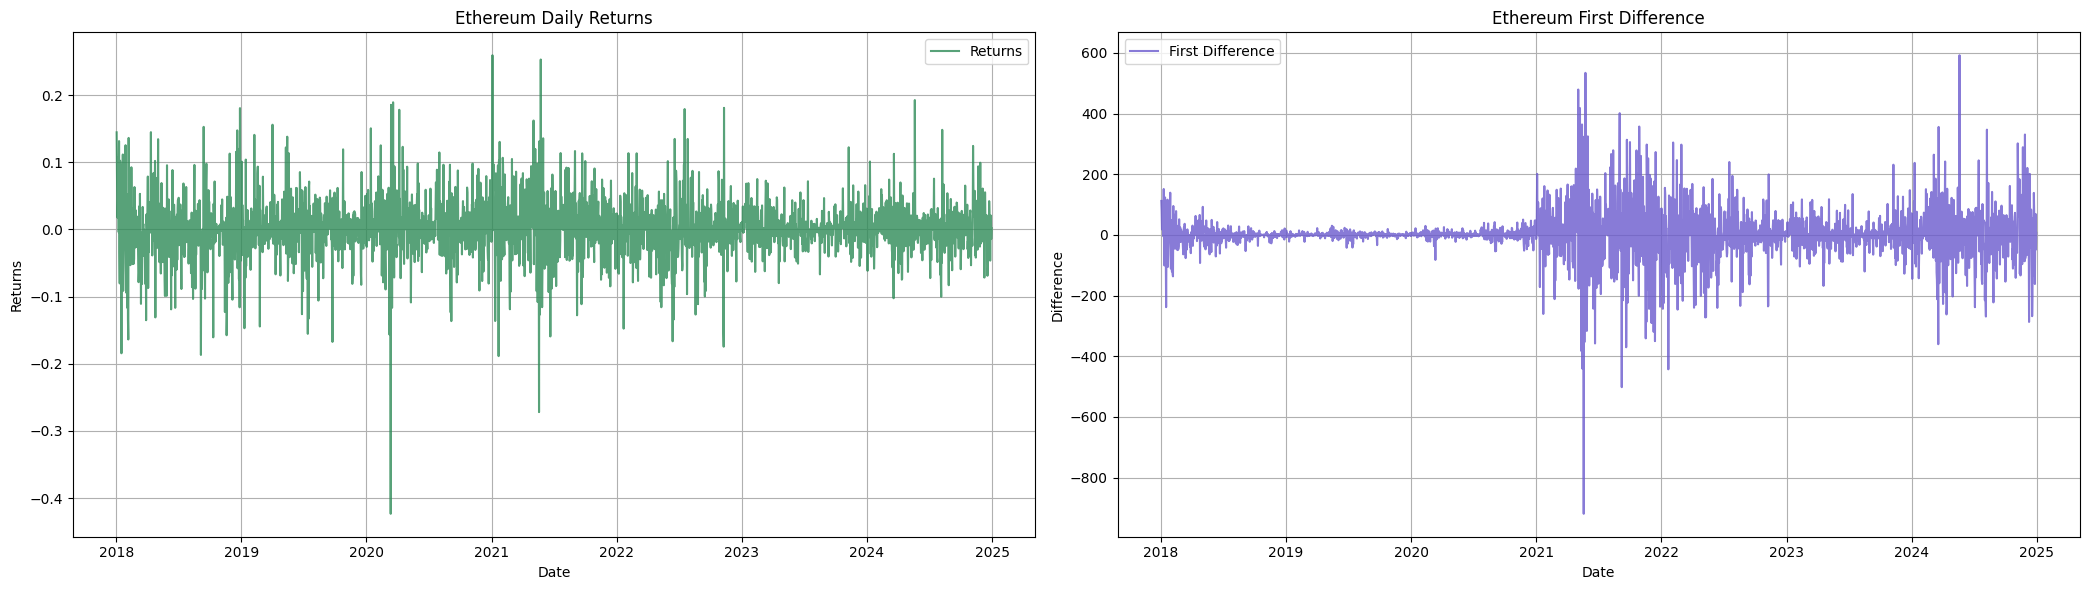

In [127]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 6), sharex=True)

# Plot Returns
sns.lineplot(ax=axes[0], x=eth_returns.index, y=eth_returns.values, color='seagreen', label='Returns', alpha=0.8)
axes[0].set_title('Ethereum Daily Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')
axes[0].grid(True)

# Plot First Differences
sns.lineplot(ax=axes[1], x=eth_diff.index, y=eth_diff.values, color='slateblue', label='First Difference', alpha=0.8)
axes[1].set_title('Ethereum First Difference')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Difference')
axes[1].grid(True)

plt.tight_layout()
plt.show()